## Bitcoin data crawling

In [1]:
from binance_historical_data import BinanceDataDumper 
import datetime 
import os 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import mplfinance as mpf
import seaborn as sns
import numpy as np
from scipy.stats import norm 


In [ ]:
data_dumper = BinanceDataDumper(
    path_dir_where_to_dump="Data", # save data in "Data" folder
    asset_class="spot", # spot market 
    data_type="klines", # "klines" means candlestick data
    data_frequency='1m' # 1 minute frequency
)

# Download historical data for BTCUSDT from Jan 1, 2024 to now 
start_date = datetime.datetime(2024, 1, 1)
data_dumper.dump_data(
    tickers=["BTCUSDT"],
    date_start=datetime.date(2024, 1, 1),
    date_end=None, # None means up to current date
    is_to_update_existing=False # do not update existing data files
)

print("Data download completed.")

---> Found overall tickers: 3436
---> Filter to asked tickers: 1
------> Tickers left: 1
Download full data for 1 tickers: 
---> Data will be saved here: d:\Tài liệu học tập\Khai phá và phân tích dữ liệu\Group Assignment\Notebooks\Data\spot
---> Data Frequency: 1m
---> Start Date: 20240101
---> End Date: 20251202


Tickers:   0%|          | 0/1 [00:00<?, ?it/s]

monthly files to download:   0%|          | 0/23 [00:00<?, ?files/s]

daily files to download:   0%|          | 0/2 [00:00<?, ?files/s]

Tried to dump data for 1 tickers:
---> For BTCUSDT new data saved for: 23 months 2 days
Data download completed.


### Integrate Bitcoin data

In [ ]:
# 1. Setup paths
base_dir = "Data"
target_path_1 = os.path.join(base_dir, "spot", "monthly", "klines", "BTCUSDT", "1m")
target_path_2 = os.path.join(base_dir, "spot", "daily", "klines", "BTCUSDT", "1m")

column_names = [
    "open_time", "open", "high", "low", "close", "volume",
    "close_time", "quote_asset_volume", "number_of_trades",
    "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignored"
]

def load_data(path):
    if not os.path.exists(path):
        return []
    files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]
    # Read without headers
    return [pd.read_csv(f, header=None, names=column_names) for f in files]

# 2. Load and Combine
print("Loading data...")
df_list = load_data(target_path_1) + load_data(target_path_2)

if not df_list:
    raise ValueError("No data found!")

df_combined = pd.concat(df_list, ignore_index=True)

# 3. Normalize Mixed Timestamps
# ---------------------------------------------------------
# Logic: A timestamp in 2024/2025 is ~1.7 trillion in ms (13 digits).
# In microseconds, it is ~1.7 quadrillion (16 digits).
# We set a threshold: if number > 10 trillion (10^13), it must be microseconds.
# ---------------------------------------------------------

# Ensure column is numeric first
df_combined['open_time'] = pd.to_numeric(df_combined['open_time'])

# Divide by 1000 ONLY where the number is huge (microseconds)
df_combined['open_time'] = np.where(
    df_combined['open_time'] > 10_000_000_000_000,  # Threshold
    df_combined['open_time'] / 1000,                # Action if True (convert us to ms)
    df_combined['open_time']                        # Action if False (keep as ms)
)

# 4. Convert to Datetime (Now everything is milliseconds)
print("Converting timestamps...")
df_combined['open_time'] = pd.to_datetime(df_combined['open_time'], unit='ms')

# 5. Clean, Sort, and Save
df_combined = df_combined.sort_values(by='open_time').drop_duplicates(subset=['open_time']).reset_index(drop=True)
df_combined = df_combined.drop(columns=['ignored', 'close_time'])  # Drop 'ignored' column

output_file = "Data/bitcoin_data_combined.csv"
df_combined.to_csv(output_file, index=False)

print(f"Success! Saved to {output_file}")
print(f"Total Rows: {len(df_combined)}")
print(f"Start Date: {df_combined['open_time'].min()}")
print(f"End Date:   {df_combined['open_time'].max()}")

Loading data...
Converting timestamps...
Success! Saved to Data/bitcoin_data_combined.csv
Total Rows: 1010880
Start Date: 2024-01-01 00:00:00
End Date:   2025-12-02 23:59:00


In [12]:
df_combined

,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2024-01-01 00:00:00,42283.58,42298.62,42261.02,42298.61,35.92724,1.519032e+06,1327,23.18766,9.803947e+05
1,2024-01-01 00:01:00,42298.62,42320.00,42298.61,42320.00,21.16779,8.955809e+05,1348,13.47483,5.700808e+05
2,2024-01-01 00:02:00,42319.99,42331.54,42319.99,42325.50,21.60391,9.143711e+05,1019,11.21801,4.747986e+05
3,2024-01-01 00:03:00,42325.50,42368.00,42325.49,42367.99,30.50730,1.291997e+06,1241,24.04878,1.018449e+06
4,2024-01-01 00:04:00,42368.00,42397.23,42367.99,42397.23,46.05107,1.951945e+06,1415,34.12804,1.446539e+06
...,...,...,...,...,...,...,...,...,...,...
1010875,2025-12-02 23:55:00,91299.99,91354.82,91272.00,91349.18,25.26430,2.307065e+06,2474,14.38350,1.313551e+06
1010876,2025-12-02 23:56:00,91349.17,91354.68,91332.69,91338.34,18.80196,1.717544e+06,1757,8.01604,7.322544e+05
1010877,2025-12-02 23:57:00,91338.34,91338.34,91313.07,91313.07,6.27380,5.729914e+05,1171,0.52385,4.784345e+04
1010878,2025-12-02 23:58:00,91313.07,91313.08,91290.02,91299.99,10.90394,9.955555e+05,1438,2.07823,1.897387e+05


## Data Understanding

In [18]:
# load data
df = pd.read_csv("Data/bitcoin_data_combined.csv")
df['open_time'] = pd.to_datetime(df['open_time'])
df.set_index('open_time', inplace=True)

# Feature engineering 
df['returns'] = df['close'].pct_change()

# Log returns 
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))

# Volatility (Percentage difference between high and low of that minute)
df['intra_volatility'] = (df['high'] - df['low']) / df['low']
df['intra_volatility'] = df['intra_volatility'] * 100  # convert to percentage
df['intra_volatility'].fillna(0, inplace=True)

# Volume in USD
df['volume_usd'] = df['volume'] * df['close']

df.dropna(inplace=True)

print("Data Loaded and Features Engineered.")
df.head()


Data Loaded and Features Engineered.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_868\15933299.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['intra_volatility'].fillna(0, inplace=True)


,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,returns,log_returns,intra_volatility,volume_usd
open_time,,,,,,,,,,,,,
2024-01-01 00:01:00,42298.62,42320.00,42298.61,42320.00,21.16779,8.955809e+05,1348,13.47483,5.700808e+05,0.000506,0.000506,0.050569,8.958209e+05
2024-01-01 00:02:00,42319.99,42331.54,42319.99,42325.50,21.60391,9.143711e+05,1019,11.21801,4.747986e+05,0.000130,0.000130,0.027292,9.143963e+05
2024-01-01 00:03:00,42325.50,42368.00,42325.49,42367.99,30.50730,1.291997e+06,1241,24.04878,1.018449e+06,0.001004,0.001003,0.100436,1.292533e+06
2024-01-01 00:04:00,42368.00,42397.23,42367.99,42397.23,46.05107,1.951945e+06,1415,34.12804,1.446539e+06,0.000690,0.000690,0.069014,1.952438e+06
2024-01-01 00:05:00,42397.22,42409.20,42385.26,42409.20,32.26766,1.368040e+06,1255,20.99093,8.899445e+05,0.000282,0.000282,0.056482,1.368446e+06


### Descriptive Statistics

In [8]:
def format(x):
    if abs(x) > 1000:
        return f"{x:,.2f}"      # Big numbers: 83,516.71
    elif abs(x) < 0.001:
        return f"{x:.8f}"       # Tiny numbers: 0.00000100
    else:
        return f"{x:.4f}"

# General summary 
desc_stats = df[['close', 'volume_usd', 'returns', 'intra_volatility']].describe()
desc_stats = desc_stats.transpose()
desc_stats = desc_stats.applymap(format)
# remove count column
desc_stats = desc_stats.drop(columns=['count'])

# skewness and kurtosis
skew = df[['returns', 'intra_volatility']].skew()
kurt = df[['returns', 'intra_volatility']].kurtosis()

print("Descriptive Statistics:")
pd.set_option('display.float_format', lambda x: '%.6f' % x)
print(desc_stats)

print("\nSkewness:")
print(skew)
print("\nKurtosis:")
print(kurt)


Descriptive Statistics:
                          mean           std         min          25%  \
close                83,516.71     22,685.75   38,558.92    63,864.52   
volume_usd        1,561,769.16  2,681,257.24    5,071.14   400,191.89   
returns             0.00000100    0.00069493     -0.0429  -0.00027876   
intra_volatility        0.0678        0.0760  0.00000798       0.0241   

                         50%           75%             max  
close              84,705.33    104,305.82      126,114.50  
volume_usd        823,059.47  1,716,043.58  256,885,789.27  
returns           0.00000000    0.00028143          0.0291  
intra_volatility      0.0486        0.0876          6.7873  

Skewness:
returns            -0.658823
intra_volatility    7.902973
dtype: float64

Kurtosis:
returns             67.881945
intra_volatility   276.230122
dtype: float64


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11156\4066055266.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc_stats = desc_stats.applymap(format)


### Visualization

In [ ]:
# Set a professional style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

# Ensure index is datetime 
if not isinstance(df.index, pd.DatetimeIndex):
    df['open_time'] = pd.to_datetime(df['open_time'])
    df.set_index('open_time', inplace=True)

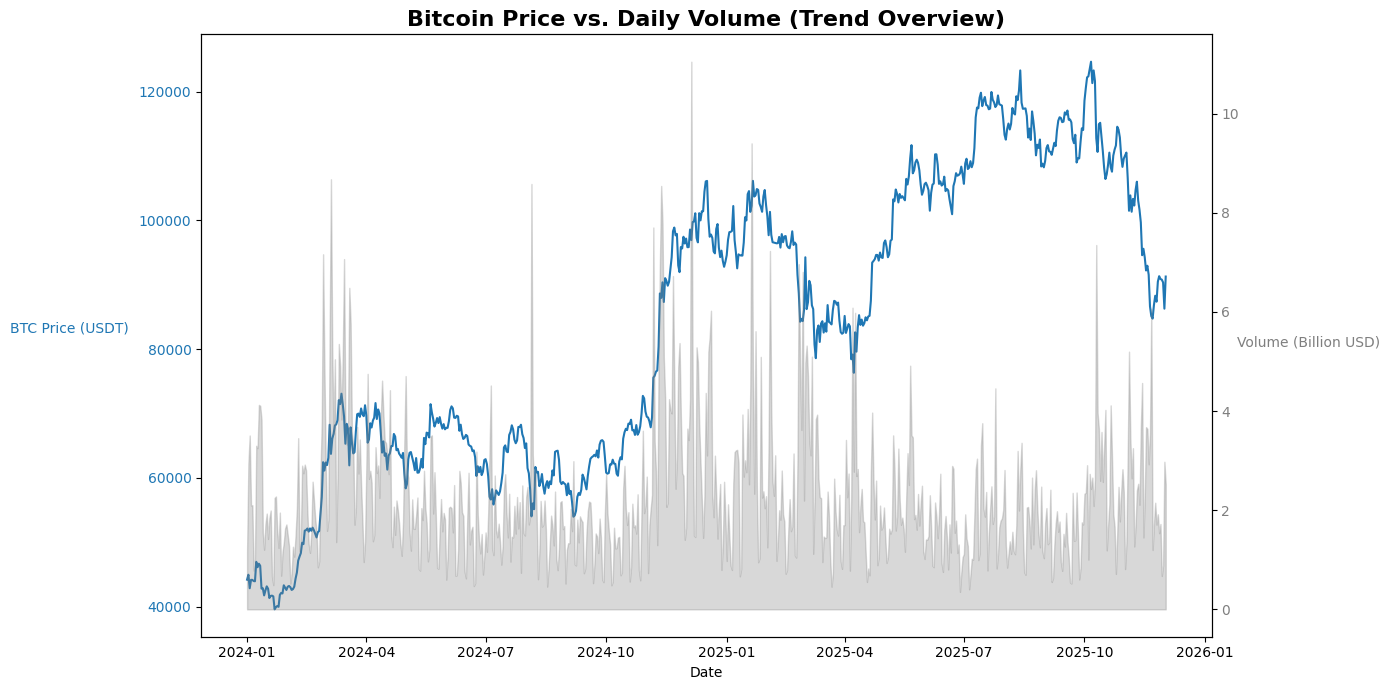

In [4]:
# Resample to Daily average for a clean trend line
df_daily = df.resample('D').agg({
    'close': 'last', 
    'volume_usd': 'sum'
})

# change volume to billions for better readability
df_daily['volume_usd'] = df_daily['volume_usd'] / 1_000_000_000  # in billions

fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Price on Left Y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price (USDT)', color=color, rotation=0, labelpad=50)
ax1.plot(df_daily.index, df_daily['close'], color=color, linewidth=1.5, label='Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(False) # Turn off grid for price to keep it clean

# Create a second Y-axis for Volume
ax2 = ax1.twinx()  
color = 'tab:gray'
ax2.set_ylabel('Volume (Billion USD)', color=color, rotation=0, labelpad=50)
ax2.fill_between(df_daily.index, df_daily['volume_usd'], color=color, alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor=color)

# Title and Layout
plt.title('Bitcoin Price vs. Daily Volume (Trend Overview)', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

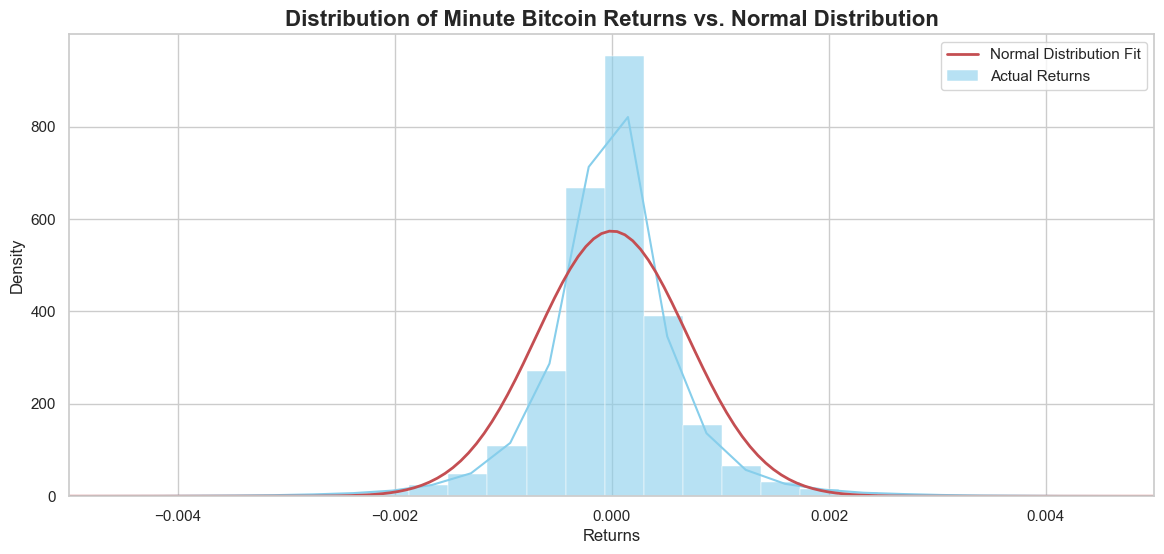

In [ ]:


plt.figure(figsize=(14, 6))

# plot the actual data histogram
sns.histplot(df['returns'], bins=200, kde=True, stat="density", color='skyblue', label='Actual Returns', alpha=0.6)

# plot the normal distribution curve    
mu, std = norm.fit(df['returns'])
x = np.linspace(df['returns'].min(), df['returns'].max(), 1000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2, label='Normal Distribution Fit')

plt.xlim(-0.005, 0.005) # Focus on central part

plt.title('Distribution of Minute Bitcoin Returns vs. Normal Distribution', fontsize=16, weight='bold')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()
plt.show()

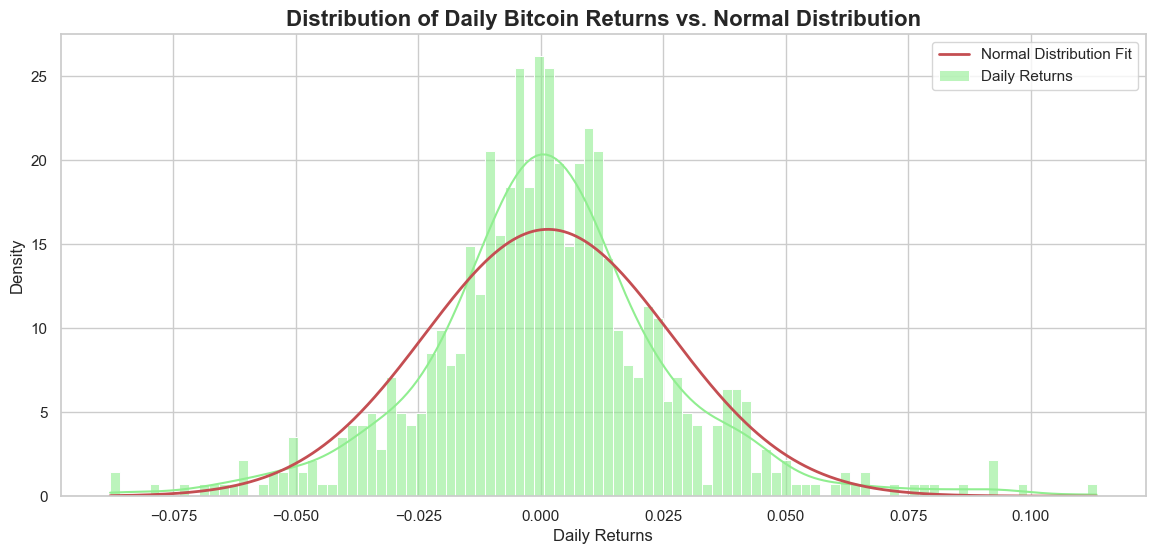

In [12]:
# distribution of daily returns
plt.figure(figsize=(14, 6))
sns.histplot(df.resample('D')['returns'].sum(), bins=100, kde=True, stat="density", color='lightgreen', label='Daily Returns', alpha=0.6)

# plot the normal distribution curve
mu_daily, std_daily = norm.fit(df.resample('D')['returns'].sum())
x_daily = np.linspace(df.resample('D')['returns'].sum().min(), df.resample('D')['returns'].sum().max(), 1000)
p_daily = norm.pdf(x_daily, mu_daily, std_daily)
plt.plot(x_daily, p_daily, 'r', linewidth=2, label='Normal Distribution Fit')


plt.title('Distribution of Daily Bitcoin Returns vs. Normal Distribution', fontsize=16, weight='bold')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.legend()
plt.show()

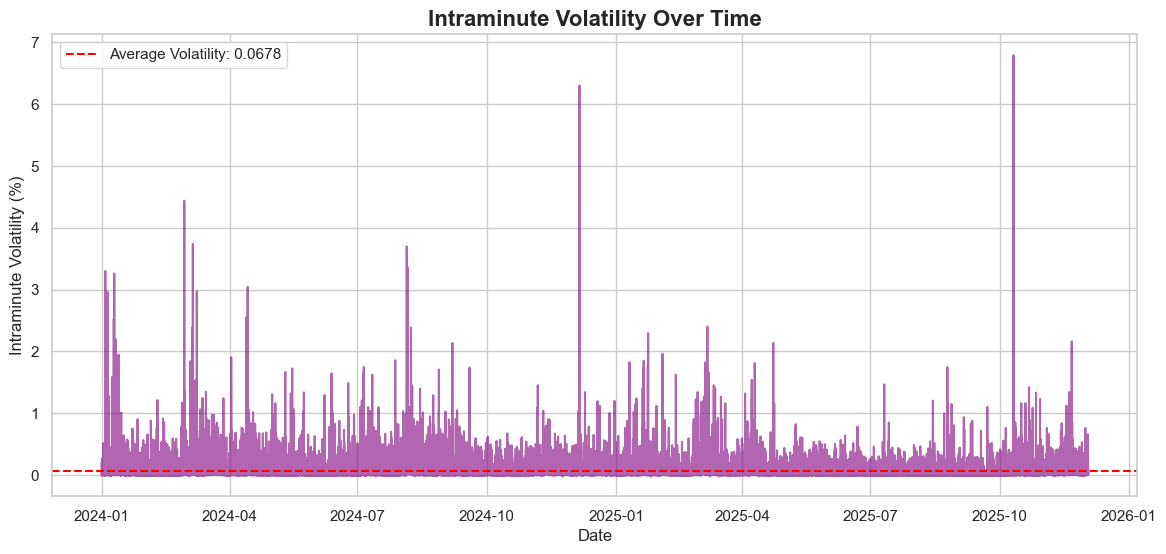

In [13]:
# Volatility Clustering 
plt.figure(figsize=(14, 6))

plt.plot(df.index, df['intra_volatility'], color='purple', alpha=0.6)

plt.title('Intraminute Volatility Over Time', fontsize=16, weight='bold')
plt.xlabel('Date')
plt.ylabel('Intraminute Volatility (%)')

avg_vol = df['intra_volatility'].mean()
plt.axhline(avg_vol, color='red', linestyle='--', label=f'Average Volatility: {avg_vol:.4f}')
plt.legend()

plt.show()

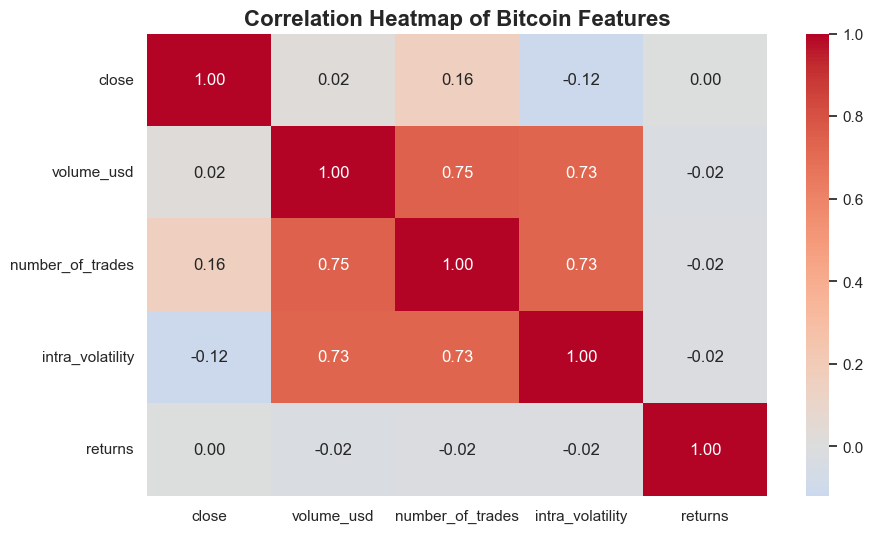

In [14]:
# Heatmap for Multivariate Correlation
corr = df[['close', 'volume_usd', 'number_of_trades', 'intra_volatility', 'returns']].corr()



plt.figure(figsize=(10, 6))

# draw heatmap  
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Bitcoin Features', fontsize=16, weight='bold')
plt.show()

## Feature Engineering for Analysis

In [19]:
df_featured = df.copy()

# drop unneeded columns for modeling: quot_asset_volume, taker_buy_base_asset_volume, taker_buy_quote_asset_volume
df_featured = df_featured.drop(columns=['quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume'])

### Standard Indicators (RSI, EMA, ATR)

In [20]:
df_featured['ema_50'] = df_featured['close'].ewm(span=50, adjust=False).mean()
df_featured['ema_200'] = df_featured['close'].ewm(span=200, adjust=False).mean()

# RSI - 14 period
delta = df_featured['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss 
df_featured['rsi_14'] = 100 - (100 / (1 + rs))

# ATR - 14 period 
high_low = df_featured['high'] - df_featured['low']
high_close = np.abs(df_featured['high'] - df_featured['close'].shift())
low_close = np.abs(df_featured['low'] - df_featured['close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = ranges.max(axis=1)
df_featured['atr_14'] = true_range.rolling(window=14).mean()

# Shock Volume
df_featured['vol_ma20'] = df_featured['volume_usd'].rolling(window=20).mean()
df_featured['is_shock_vol'] = np.where(df_featured['volume_usd'] > 2 * df_featured['vol_ma20'], 1, 0)

df_featured.tail()

,open,high,low,close,volume,number_of_trades,returns,log_returns,intra_volatility,volume_usd,ema_50,ema_200,rsi_14,atr_14,vol_ma20,is_shock_vol
open_time,,,,,,,,,,,,,,,,
2025-12-02 23:55:00,91299.99,91354.82,91272.00,91349.18,25.26430,2474,0.000539,0.000539,0.090740,2.307873e+06,91557.348874,91588.987370,35.627112,43.109286,1.225094e+06,0
2025-12-02 23:56:00,91349.17,91354.68,91332.69,91338.34,18.80196,1757,-0.000119,-0.000119,0.024077,1.717340e+06,91548.760290,91586.493367,35.874651,43.514286,1.274543e+06,0
2025-12-02 23:57:00,91338.34,91338.34,91313.07,91313.07,6.27380,1171,-0.000277,-0.000277,0.027674,5.728799e+05,91539.517534,91583.772736,32.963432,44.894286,1.258975e+06,0
2025-12-02 23:58:00,91313.07,91313.08,91290.02,91299.99,10.90394,1438,-0.000143,-0.000143,0.025260,9.955296e+05,91530.124297,91580.949027,34.868987,43.880000,1.245679e+06,0
2025-12-02 23:59:00,91299.99,91300.00,91269.38,91277.88,17.50326,2048,-0.000242,-0.000242,0.033549,1.597660e+06,91520.232364,91577.933415,34.111374,44.287143,1.201608e+06,0


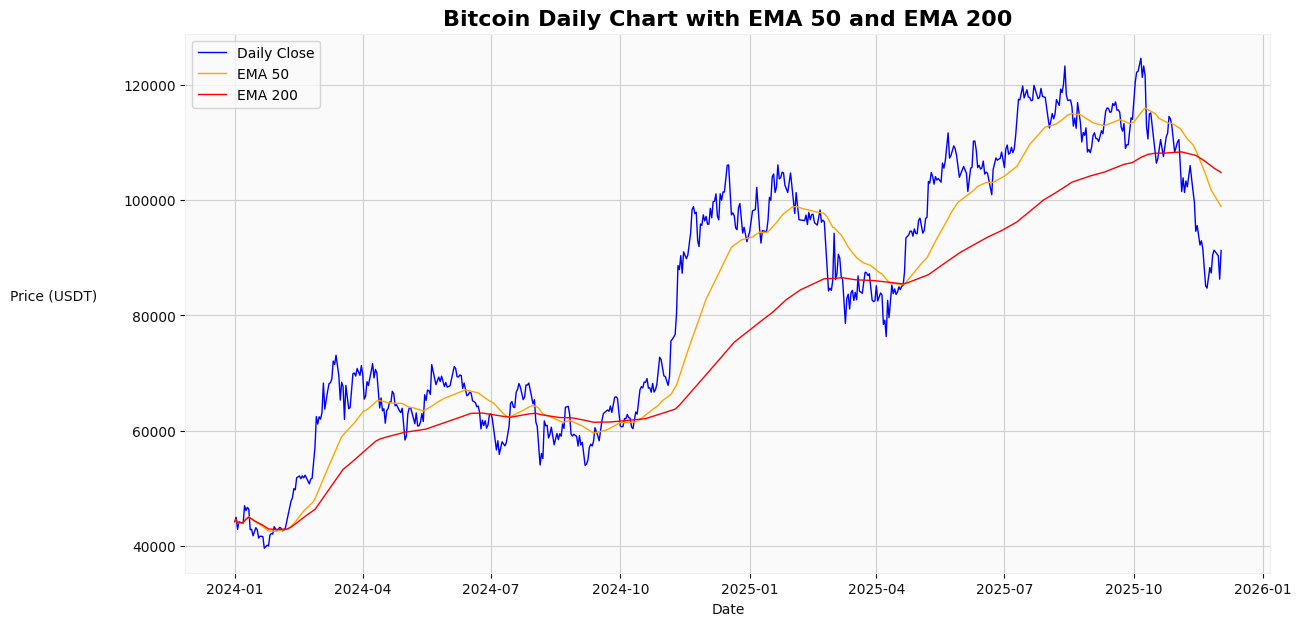

In [44]:
# Chart 1: The Macro Trend (Daily aggregation)
df_daily = df.resample('D').agg({
    'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'
})

df_daily['ema_50'] = df_daily['close'].ewm(span=50).mean()
df_daily['ema_200'] = df_daily['close'].ewm(span=200).mean()

# plot the daily chart with EMAs using matplotlib
plt.figure(figsize=(14, 7)) 
plt.plot(df_daily.index, df_daily['close'], label='Daily Close', color='blue', linewidth=1)
plt.plot(df_daily.index, df_daily['ema_50'], label='EMA 50', color='orange', linewidth=1)
plt.plot(df_daily.index, df_daily['ema_200'], label='EMA 200', color='red', linewidth=1)
plt.title('Bitcoin Daily Chart with EMA 50 and EMA 200', fontsize=16, weight='bold')
plt.xlabel('Date')
plt.ylabel('Price (USDT)', rotation=0, labelpad=50)
plt.legend()
plt.show()

### MARKET STRUCTURE (Fractals: HH, LL, LH, HL)

In [21]:
def calculate_market_structure(df, lookback=20, lookforward=10):
    df_struct = df.copy()

    
    # Identify Swing Points 
    is_high_peak = pd.Series(True, index=df_struct.index)
    is_low_valley = pd.Series(True, index=df_struct.index)
    
    # Check left side (Past)
    for i in range(1, lookback + 1):
        is_high_peak &= df_struct['high'] > df_struct['high'].shift(i)
        is_low_valley &= df_struct['low'] < df_struct['low'].shift(i)
        
    # Check right side (Future)
    for i in range(1, lookforward + 1):
        is_high_peak &= df_struct['high'] >= df_struct['high'].shift(-i)
        is_low_valley &= df_struct['low'] <= df_struct['low'].shift(-i)
    
    df_struct['is_swing_high'] = is_high_peak.fillna(False)
    df_struct['is_swing_low'] = is_low_valley.fillna(False)
    
    # Label the Points (HH, HL, LH, LL)
    df_struct['structure_label'] = np.nan
    
    # Get indices of swing points
    high_indices = df_struct.index[df_struct['is_swing_high']]
    low_indices = df_struct.index[df_struct['is_swing_low']]


    # Compare the current swing high to the previous swing high
    prev_high = df_struct['high'].loc[high_indices[0]] # Start with the first one 
    
    for i in high_indices[1:]: # skip the very first one 
        current_high = df_struct['high'].loc[i]
        
        if current_high > prev_high:
            df_struct.at[i, 'structure_label'] = 'HH' # Higher High (Bullish)
        else:
            df_struct.at[i, "structure_label"] = "LH" # Lower High (Bearish)
        
        prev_high = current_high # update previous for the next loop
    
    # Label LOWS (LL and HL)
    # Compare the current swing low to the previous swing low
    prev_low = df_struct['low'].loc[low_indices[0]]
    
    for i in low_indices[1:]:
        current_low = df_struct['low'].loc[i]
        
        if current_low < prev_low:
            df_struct.at[i, "structure_label"] = 'LL' # Lower Low (Bearish)
        else:
            df_struct.at[i, "structure_label"] = "HL" # Higher Low (Bullish)
        
        prev_low = current_low 
    
    return df_struct
    
df_featured = calculate_market_structure(df_featured)
df_featured.tail()
    

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_868\3552936188.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'HH' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_struct.at[i, 'structure_label'] = 'HH' # Higher High (Bullish)


,open,high,low,close,volume,number_of_trades,returns,log_returns,intra_volatility,volume_usd,ema_50,ema_200,rsi_14,atr_14,vol_ma20,is_shock_vol,is_swing_high,is_swing_low,structure_label
open_time,,,,,,,,,,,,,,,,,,,
2025-12-02 23:55:00,91299.99,91354.82,91272.00,91349.18,25.26430,2474,0.000539,0.000539,0.090740,2.307873e+06,91557.348874,91588.987370,35.627112,43.109286,1.225094e+06,0,False,False,NaN
2025-12-02 23:56:00,91349.17,91354.68,91332.69,91338.34,18.80196,1757,-0.000119,-0.000119,0.024077,1.717340e+06,91548.760290,91586.493367,35.874651,43.514286,1.274543e+06,0,False,False,NaN
2025-12-02 23:57:00,91338.34,91338.34,91313.07,91313.07,6.27380,1171,-0.000277,-0.000277,0.027674,5.728799e+05,91539.517534,91583.772736,32.963432,44.894286,1.258975e+06,0,False,False,NaN
2025-12-02 23:58:00,91313.07,91313.08,91290.02,91299.99,10.90394,1438,-0.000143,-0.000143,0.025260,9.955296e+05,91530.124297,91580.949027,34.868987,43.880000,1.245679e+06,0,False,False,NaN
2025-12-02 23:59:00,91299.99,91300.00,91269.38,91277.88,17.50326,2048,-0.000242,-0.000242,0.033549,1.597660e+06,91520.232364,91577.933415,34.111374,44.287143,1.201608e+06,0,False,False,NaN


### SMART MONEY CONCEPTS (Order Blocks, Fair Value Gaps)

In [22]:
def calculate_smart_money_features(df):
    df_smc = df.copy()
    
    # ==========================================
    # 1. SETUP: Candle Anatomy
    # ==========================================
    
    # Body size (Absolute value)
    body_size = np.abs(df_smc['close'] - df_smc['open'])
    
    # Total range (High - Low)
    candle_range = df_smc['high'] - df_smc['low']
    
    # Upper and Lower Wicks
    # Upper Wick = High - Max(Open, Close)
    upper_wick = df_smc['high'] - df_smc[['open', 'close']].max(axis=1)
    # Lower Wick = Min(Open, Close) - Low
    lower_wick = df_smc[['open', 'close']].min(axis=1) - df_smc['low']
    
    # Calculate Shock Volume
    # Volume > 2x average of last 20 candles
    avg_vol = df_smc['volume'].rolling(window=20).mean()
    is_shock_vol = df_smc['volume'] > (2 * avg_vol)
    
    # ==========================================
    # 2. ORDER BLOCKS 
    # ==========================================
    
    # Bullish Pinbar, potential demand zone
    df_smc['is_bullish_ob'] = (
        (lower_wick > 2 * body_size) & # Long tail 
        (lower_wick > upper_wick) & # Tail is longer than nose
        (is_shock_vol) # Whales are active
    )
    
    # Bearish Pinbar, potential supply zone
    df_smc['is_bearish_ob'] = (
        (upper_wick > 2 * body_size) & # Long nose
        (upper_wick > lower_wick) &  # Nose is longer than tail
        (is_shock_vol) # Whales are active
    )
    
    # ==========================================
    # 3. FAIR VALUE GAPS (FVG) 
    # ==========================================
    
    
    prev_high = df_smc['high'].shift(2)
    prev_low = df_smc['low'].shift(2)
    
    threshold = df_smc['close'] * 0.0005
    
    
    bullish_gap_size = df_smc['low'] - prev_high
    
    # Bullish FVG: Low > Prev High
    df_smc['is_fvg_bullish'] = (
        (df_smc['low'] > prev_high) & # The Gap exists
        (bullish_gap_size > threshold) & # Gap is large enough
        (df_smc['close'] > df_smc['open']) # Current candle is green
    )
    
    bearish_gap_size = prev_low - df_smc['high']
    
    # Bearish FVG: High < Prev Low
    df_smc['is_fvg_bearish'] = (
        (df_smc['high'] < prev_low) & # The Gap exists
        (bearish_gap_size > threshold) & # Gap is large enough
        (df_smc['close'] < df_smc['open']) # Current candle is Red
    )
    
    # Clean up, fill NaNs with False
    
    cols_to_fill = ['is_bullish_ob', 'is_bearish_ob', 'is_fvg_bullish', 'is_fvg_bearish']
    df_smc[cols_to_fill] = df_smc[cols_to_fill].fillna(False)
    
    return df_smc

df_featured = calculate_smart_money_features(df_featured)

print("Bullish Order Blocks found:", df_featured['is_bullish_ob'].sum())
print("Bullish FVGs found:", df_featured['is_fvg_bullish'].sum())


df_featured[df_featured['is_bullish_ob'] == True][['close', 'is_bullish_ob', 'is_fvg_bullish']].tail()
    

Bullish Order Blocks found: 8169
Bullish FVGs found: 29318


,close,is_bullish_ob,is_fvg_bullish
open_time,,,
2025-12-02 08:55:00,86411.97,True,False
2025-12-02 11:40:00,87342.66,True,False
2025-12-02 18:01:00,91555.53,True,False
2025-12-02 22:05:00,91837.59,True,False
2025-12-02 22:09:00,91555.76,True,False


### Summary of Features

In [ ]:
# Numerical Stats

def format(x):
    if abs(x) > 1000:
        return f"{x:,.2f}"      # Big numbers: 83,516.71
    elif abs(x) < 0.001:
        return f"{x:.8f}"       # Tiny numbers: 0.00000100
    else:
        return f"{x:.4f}"

numerical_cols = ['intra_volatility', 'rsi_14', 'atr_14']

desc_stats = df_featured[numerical_cols].describe()



desc_stats = desc_stats.applymap(format)
desc_stats = desc_stats.transpose()
# remove count column
desc_stats = desc_stats.drop(columns=['count'])
print("Descriptive Statistics of Featured Data:")
print(desc_stats)

Descriptive Statistics of Featured Data:
                     mean      std         min      25%      50%      75%  \
intra_volatility   0.0678   0.0760  0.00000798   0.0241   0.0486   0.0876   
rsi_14            50.1772  17.0892  0.00000000  38.0647  50.0485  62.2160   
atr_14            54.5342  48.4507      0.0100  25.1393  42.1014  68.8479   

                       max  
intra_volatility    6.7873  
rsi_14            100.0000  
atr_14            3,456.00  


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_868\2049257837.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc_stats = desc_stats.applymap(format)


In [56]:
# Boolean/Signal Frequency
bool_cols = ['is_shock_vol', 'is_bullish_ob', 'is_bearish_ob', 'is_fvg_bullish', 'is_fvg_bearish']
bool_cols_rename = {
    'is_shock_vol': 'Shock Volume',
    'is_bullish_ob': 'Bullish Order Block',
    'is_bearish_ob': 'Bearish Order Block',
    'is_fvg_bullish': 'Bullish FVG',
    'is_fvg_bearish': 'Bearish FVG'
}

bool_summary = {col: df_featured[col].sum() for col in bool_cols}
total = len(df_featured)
print("\nBoolean Feature Counts:")
for col, count in bool_summary.items():
    print(f"{bool_cols_rename[col]}: {count} ({(count/total)*100:.2f}%)")


Boolean Feature Counts:
Shock Volume: 94059 (9.30%)
Bullish Order Block: 8169 (0.81%)
Bearish Order Block: 7542 (0.75%)
Bullish FVG: 29317 (2.90%)
Bearish FVG: 27969 (2.77%)


In [37]:
# remove rows with nah values in "rsi_14" and "atr_14"
df_featured = df_featured.dropna(subset=['rsi_14', 'atr_14'])
# Save to csv file
df_featured.to_csv("Data/bitcoin_data_feature_engineered.csv", index=True)

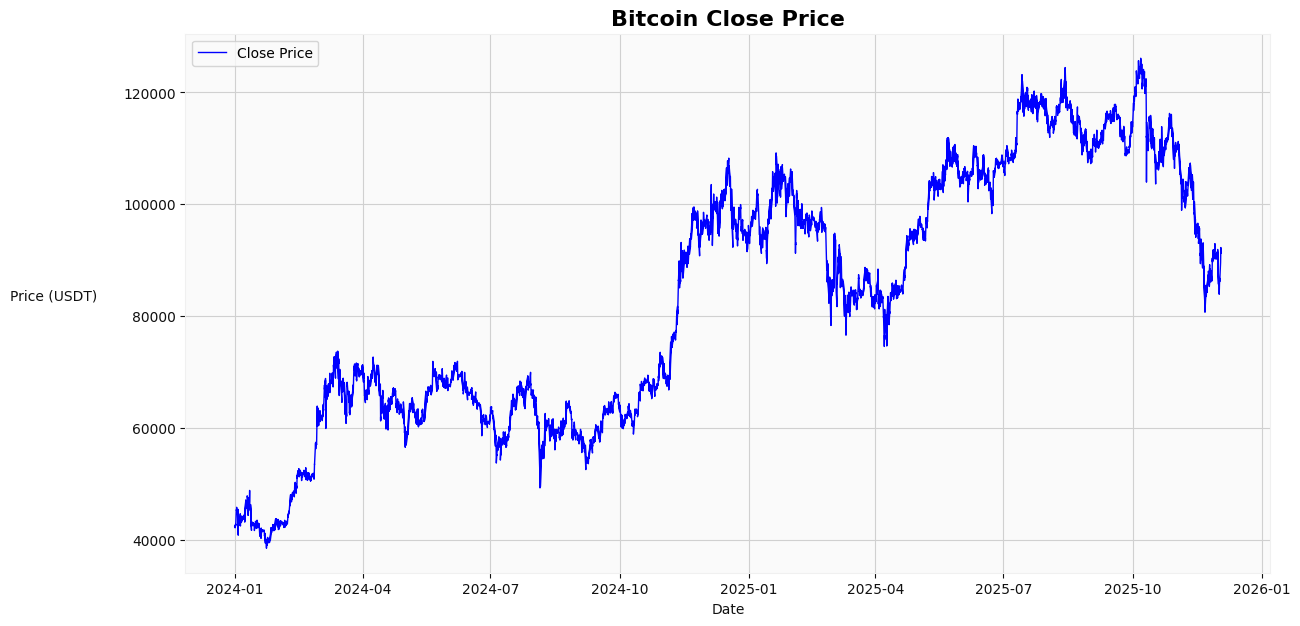

In [71]:
# visualize the close prices of df 
plt.figure(figsize=(14, 7))
plt.plot(df_featured.index, df_featured['close'], label='Close Price', color='blue', linewidth=1)

plt.title('Bitcoin Close Price', fontsize=16, weight='bold')
plt.xlabel('Date')
plt.ylabel('Price (USDT)', rotation=0, labelpad=50)
plt.legend()
plt.show()

## Data Clustering

In [2]:
df_featured = pd.read_csv("Data/bitcoin_data_feature_engineered.csv", parse_dates=['open_time'])
df_featured.set_index('open_time', inplace=True)
df_featured.head()

,open,high,low,close,volume,number_of_trades,returns,log_returns,intra_volatility,volume_usd,...,atr_14,vol_ma20,is_shock_vol,is_swing_high,is_swing_low,structure_label,is_bullish_ob,is_bearish_ob,is_fvg_bullish,is_fvg_bearish
open_time,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:14:00,42480.16,42488.09,42465.78,42488.00,34.04769,1080,0.000185,0.000185,0.052536,1.446618e+06,...,23.755000,NaN,0,False,False,NaN,False,False,False,False
2024-01-01 00:15:00,42488.00,42516.46,42482.47,42510.00,33.40445,1709,0.000518,0.000518,0.080009,1.420023e+06,...,24.655000,NaN,0,False,False,NaN,False,False,False,False
2024-01-01 00:16:00,42510.01,42554.57,42510.00,42541.27,61.90631,2049,0.000736,0.000735,0.104846,2.633573e+06,...,27.013571,NaN,0,False,False,NaN,False,False,True,False
2024-01-01 00:17:00,42541.27,42541.27,42503.36,42503.36,27.71049,833,-0.000891,-0.000892,0.089193,1.177789e+06,...,26.685000,NaN,0,False,False,NaN,False,False,False,False
2024-01-01 00:18:00,42503.36,42503.37,42467.28,42474.03,25.78878,953,-0.000690,-0.000690,0.084983,1.095353e+06,...,27.174286,NaN,0,False,False,NaN,False,False,False,False


In [3]:
df_featured.columns

Index(['open', 'high', 'low', 'close', 'volume', 'number_of_trades', 'returns',
       'log_returns', 'intra_volatility', 'volume_usd', 'ema_50', 'ema_200',
       'rsi_14', 'atr_14', 'vol_ma20', 'is_shock_vol', 'is_swing_high',
       'is_swing_low', 'structure_label', 'is_bullish_ob', 'is_bearish_ob',
       'is_fvg_bullish', 'is_fvg_bearish'],
      dtype='object')

### Preprocessing for Clustering

In [28]:
def create_wyckoff_features(df):
    df_w = df.copy()
    
    df_w['trend_maturity'] = (df_w['ema_50'] - df_w['ema_200']) / df_w['close'] * 100
    
    df_w['trend_tactical'] = (df_w['close'] - df_w['ema_50']) / df_w['ema_50'] * 100
    
    # efficiency 
    # high efficiency = markup / markdown  
    # low efficiency = accumulation / distribution 
    epsilon = 1e-9
    range_len = df_w['high'] - df_w['low'] 
    body_len = abs(df_w['close'] - df_w['open'])
    
    raw_efficiency = body_len / (range_len + epsilon)
    df_w['efficiency_regime'] = raw_efficiency.rolling(window=20).mean()
    
    # Volume   
    df_w['rel_volume'] = df_w['volume_usd'] / df_w['vol_ma20']
    df_w['vol_regime'] = df_w['rel_volume'].rolling(window=1).mean()
    
    # Structure 
    structure_score = np.zeros(len(df_w))
    current_score = 0 
    decay = 0.98
    
    bull_ob = df_w['is_bullish_ob'].fillna(0).values
    bear_ob = df_w['is_bearish_ob'].fillna(0).values
    fvg_bull = df_w['is_fvg_bullish'].fillna(0).values
    fvg_bear = df_w['is_fvg_bearish'].fillna(0).values
    
    for i in range(1, len(df_w)):
        current_score *= decay
        
        # OBs are structural pivots
        if bull_ob[i] == 1: current_score += 1.0
        if bear_ob[i] == 1: current_score -= 1.0 
        
        # Momentum from FVGs
        if fvg_bull[i] == 1: current_score += 0.5
        if fvg_bear[i] == 1: current_score -= 0.5
        
        structure_score[i] = current_score
    df_w['structure_score'] = structure_score
    
    final_features = [
        "trend_tactical", # short term location
        "trend_maturity", # long term location
        "efficiency_regime", # candle characteristic
        "vol_regime",      # effort
        "structure_score"  # market structure
    ]
    
    return df_w[final_features].dropna()

df_clustering = create_wyckoff_features(df_featured)
df_clustering.head()

    

,trend_tactical,trend_maturity,efficiency_regime,vol_regime,structure_score
open_time,,,,,
2024-01-01 00:33:00,-0.074841,0.124381,0.625290,0.939447,-0.474120
2024-01-01 00:34:00,-0.096583,0.120230,0.635432,0.441716,-0.464638
2024-01-01 00:35:00,-0.100163,0.115989,0.624508,0.546014,-0.455345
2024-01-01 00:36:00,-0.050647,0.113236,0.634671,2.111445,-0.446238
2024-01-01 00:37:00,0.033977,0.113048,0.625722,2.597866,-0.437314


### Clustering and Interpretation

In [29]:
import sklearn
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans


# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(df_clustering)

# Cluster using KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

df_clustering['cluster'] = clusters

summary = df_clustering.groupby('cluster').mean()

# add count to see distribution
summary['count'] = df_clustering['cluster'].value_counts()


print("Cluster Summary:")
print(summary)



Cluster Summary:
         trend_tactical  trend_maturity  efficiency_regime  vol_regime  \
cluster                                                                  
0             -0.001507        0.011473           0.693043    3.776808   
1              0.156834        0.215293           0.586386    0.882570   
2              0.001188        0.013713           0.751814    0.826578   
3             -0.178667       -0.263822           0.573793    0.893530   

         structure_score   count  
cluster                           
0               0.048775   56643  
1               0.737825  282328  
2              -0.018536  432128  
3              -0.575672  239737  


### Evaluation of Clustering

In [30]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

labels = kmeans.labels_
labels

# Metric 1: Inertia
print(f"Inertia: {kmeans.inertia_:.4f}") 
print(f"Average Inertia per sample: {kmeans.inertia_ / len(X):.6f}")

# Metric 2: Silhouette Score
sample_size = 50000
if len(X) > sample_size:
    indices = np.random.choice(len(X), sample_size, replace=False)
    X_sample = X[indices]
    labels_sample = labels[indices]
else:
    X_sample = X
    labels_sample = labels
    
sil_score = silhouette_score(X_sample, labels_sample)
print(f"Silhouette Score: {sil_score:.4f}")

# Metric 3: Davies-Bouldin Index
db_score = davies_bouldin_score(X, labels)
print(f"Davies-Bouldin Index: {db_score:.4f}")

# Metric 4: Calinski-Harabasz Index
ch_score = calinski_harabasz_score(X, labels)
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

Inertia: 3067564.4824
Average Inertia per sample: 3.034681
Silhouette Score: 0.2133
Davies-Bouldin Index: 1.3583
Calinski-Harabasz Index: 218212.1221


In [34]:
df_clustering['cluster'].value_counts()

cluster
2    432128
1    282328
3    239737
0     56643
Name: count, dtype: int64

### visualization of Clusters

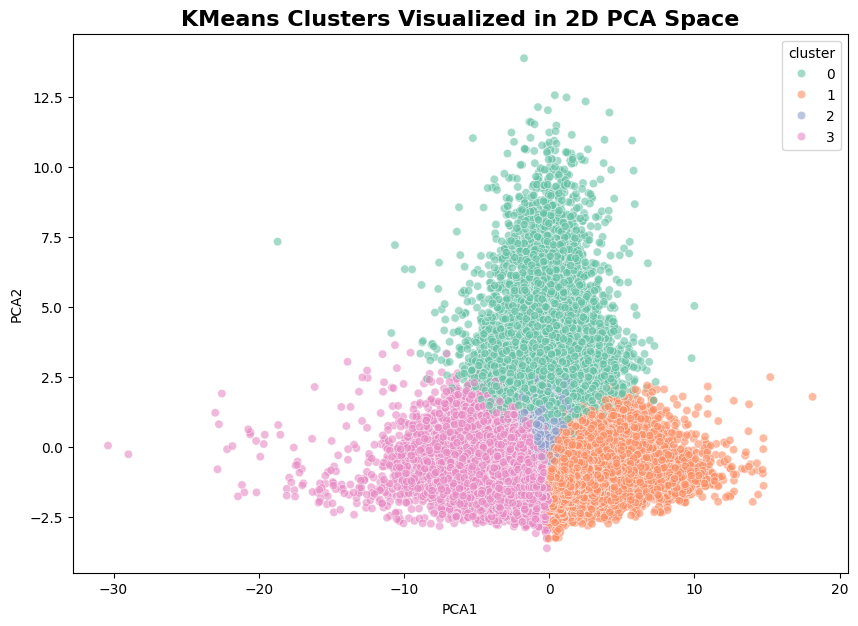

In [42]:
# Visualize Clusters in 2D using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['cluster'] = df_clustering['cluster'].values
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='cluster', palette='Set2', alpha=0.6)
plt.title('KMeans Clusters Visualized in 2D PCA Space', fontsize=16, weight='bold')
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13984\1123264031.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='bfill')


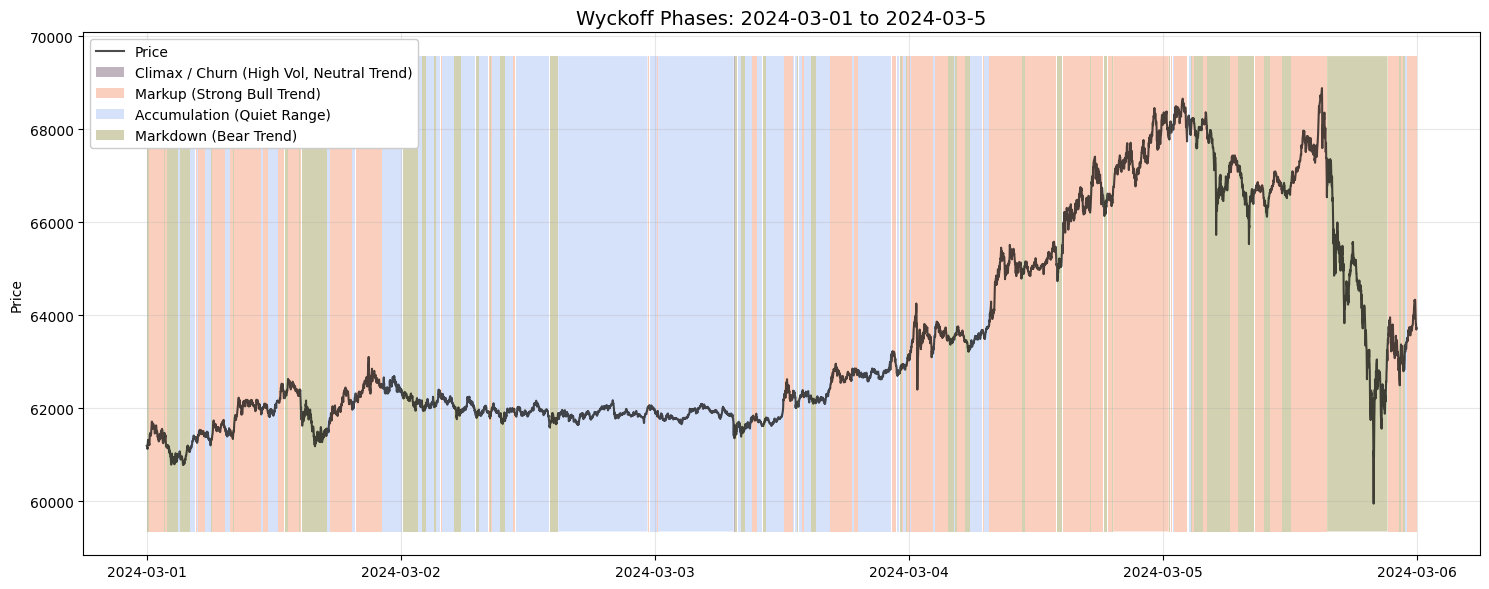

In [71]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_wyckoff_zoom(df_clusters, df_prices, start_date, end_date, smooth_window=10):
    """
    Plots Price vs Wyckoff Clusters for a specific time interval.
    """
    # 1. Prepare Data Slice
    subset = df_clusters.loc[start_date:end_date].copy()
    subset['close'] = df_prices.loc[start_date:end_date, 'close']
    
    # 2. Apply Smoothing 
    subset['smooth_cluster'] = subset['cluster'].rolling(window=smooth_window).apply(
        lambda x: pd.Series(x).mode()[0] if not pd.Series(x).mode().empty else x[int(smooth_window/2)], 
        raw=True
    ).fillna(method='bfill')

    # 3. Define Colors 
    colors = {0: "#2b0527", 1: "#f5632a", 2: "#789cf0", 3: "#6d6b03"}
    labels = {0: 'Climax / Churn (High Vol, Neutral Trend)', 1: 'Markup (Strong Bull Trend)', 2: 'Accumulation (Quiet Range)', 3: 'Markdown (Bear Trend)'}

    # 4. Plot
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Plot Price Line
    ax.plot(subset.index, subset['close'], color='black', linewidth=1.5, alpha=0.7, label='Price')

    # Paint Background (Vectorized)
    for cluster_id, color in colors.items():
        mask = (subset['smooth_cluster'] == cluster_id)
        ax.fill_between(
            subset.index, 
            y1=subset['close'].min() * 0.99, # Dynamic Y-limits for the zoom
            y2=subset['close'].max() * 1.01, 
            where=mask, 
            color=color, alpha=0.3, 
            linewidth=0, step='mid',
            label=labels[cluster_id]
        )

    # Styling
    ax.set_title(f"Wyckoff Phases: {start_date} to {end_date}", fontsize=14)
    ax.set_ylabel("Price")
    ax.legend(loc='upper left', frameon=True, fancybox=True, framealpha=1)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



plot_wyckoff_zoom(df_clustering, df_featured, '2024-03-01', '2024-03-5', smooth_window=10)

## Association Pattern Mining

In [136]:
df_association = df_clustering.copy()

# get close, high, low, atr_14 from df_featured
df_association[['close', 'high', 'low', 'atr_14', 'rsi_14']] = df_featured[['close', 'high', 'low', 'atr_14', 'rsi_14']]
df_association.head()

,trend_tactical,trend_maturity,efficiency_regime,vol_regime,structure_score,cluster,close,high,low,atr_14,rsi_14
open_time,,,,,,,,,,,
2024-01-01 00:33:00,-0.074841,0.124381,0.625290,0.939447,-0.474120,2,42373.82,42376.00,42367.44,21.108571,28.236499
2024-01-01 00:34:00,-0.096583,0.120230,0.635432,0.441716,-0.464638,2,42362.93,42373.82,42354.19,21.996429,26.581786
2024-01-01 00:35:00,-0.100163,0.115989,0.624508,0.546014,-0.455345,3,42359.68,42362.94,42355.36,21.575714,27.948089
2024-01-01 00:36:00,-0.050647,0.113236,0.634671,2.111445,-0.446238,2,42379.80,42379.80,42357.57,22.085000,29.753425
2024-01-01 00:37:00,0.033977,0.113048,0.625722,2.597866,-0.437314,0,42416.27,42424.21,42379.79,24.396429,38.721592


### Data Preparation

In [137]:
def prepare_target(df, horizon=60, atr_multiplier=3.0):
    data = df.copy()
    
    # 1. Setup FixedForwardWindow (Look ahead)
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=horizon)
    data['future_high'] = data['high'].rolling(window=indexer).max()
    data['future_low'] = data['low'].rolling(window=indexer).min()
    
    # 2. Define Barriers
    bull_barrier = data['close'] + (data['atr_14'] * atr_multiplier)
    bear_barrier = data['close'] - (data['atr_14'] * atr_multiplier)
    
    # 3. The Logic Fix:
    # We define specific boolean flags first
    hit_profit = data['future_high'] >= bull_barrier
    hit_stop   = data['future_low'] <= bear_barrier
    
    # 4. Construct Conditions with PRIORITY
    conditions = [
        # PRIORITY 1: The "Whipsaw" (Hit BOTH) -> Treat as LOSS or NEUTRAL
        # If volatility is so high it hits both, it's gambling, not trading. 
        # We mark it 'Dump' (to avoid buying) or 'Volatile' (to ignore).
        (hit_profit & hit_stop), 
        
        # PRIORITY 2: Hit Stop Loss ONLY -> DUMP
        hit_stop,
        
        # PRIORITY 3: Hit Take Profit ONLY -> PUMP
        hit_profit
    ]
    
    # Corresponding choices
    choices = [
        'Dump', # Conservative: If it hits both, treat it as a Dump (Don't trade this!)
        'Dump', 
        'Pump'
    ]
    
    data['target_label'] = np.select(conditions, choices, default='Sideways')
    
    # Filter bad data
    data.loc[data['atr_14'] <= 0, 'target_label'] = 'Sideways'
    
    return data.dropna(subset=['target_label'])

df_association = prepare_target(df_association, horizon=60, atr_multiplier=6.0)
df_association['target_label'].value_counts()
    
    

target_label
Dump        380018
Sideways    327162
Pump        303656
Name: count, dtype: int64

In [138]:
df_association.head()

,trend_tactical,trend_maturity,efficiency_regime,vol_regime,structure_score,cluster,close,high,low,atr_14,rsi_14,future_high,future_low,target_label
open_time,,,,,,,,,,,,,,
2024-01-01 00:33:00,-0.074841,0.124381,0.625290,0.939447,-0.474120,2,42373.82,42376.00,42367.44,21.108571,28.236499,42555.76,42354.19,Pump
2024-01-01 00:34:00,-0.096583,0.120230,0.635432,0.441716,-0.464638,2,42362.93,42373.82,42354.19,21.996429,26.581786,42565.22,42354.19,Pump
2024-01-01 00:35:00,-0.100163,0.115989,0.624508,0.546014,-0.455345,3,42359.68,42362.94,42355.36,21.575714,27.948089,42574.50,42355.36,Pump
2024-01-01 00:36:00,-0.050647,0.113236,0.634671,2.111445,-0.446238,2,42379.80,42379.80,42357.57,22.085000,29.753425,42628.81,42357.57,Pump
2024-01-01 00:37:00,0.033977,0.113048,0.625722,2.597866,-0.437314,0,42416.27,42424.21,42379.79,24.396429,38.721592,42689.11,42379.79,Pump


In [139]:
def discretize_features(df):
    data = df.copy()
    
    # RSI
    data['RSI_Bin'] = pd.cut(data['rsi_14'],
                             bins=[-np.inf, 30, 45, 55, 70, np.inf],
                             labels=['RSI_Oversold', 'RSI_Bearish', 'RSI_Neutral', 'RSI_Bullish', 'RSI_Overbought'])
    
    # Volume Regime 
    data['Vol_Bin'] = pd.cut(data['vol_regime'],
                             bins=[-np.inf, 0.5, 1.5, 3.0, np.inf],
                             labels=['Vol_Low', 'Vol_Normal', 'Vol_High', 'Vol_Shock'])

    # Trend Tactical
    data['Trend_Bin'] = pd.cut(data['trend_tactical'],
                              bins=[-np.inf, -0.6, -0.1, 0.1, 0.6, np.inf],
                              labels=['Trend_Overextended_Bear', 'Trend_Bearish', 'Trend_Neutral', 'Trend_Bullish', 'Trend_Overextended_Bull'])
    
    # Structure Score
    data['Struct_Bin'] = pd.cut(data['structure_score'],
                                bins=[-np.inf, -0.5, 0.5, np.inf],
                                labels=['Struct_Bear', 'Struct_Neutral', 'Struct_Bull'])
    
    # Wyckoff Cluster
    cluster_map = {
        0: 'Phase_Climax',
        1: 'Phase_Markup',
        2: 'Phase_Accumulation',
        3: 'Phase_Markdown'
    }
    
    data['Phase_Label'] = data['cluster'].map(cluster_map)
    
    # Clean up
    cols_to_keep = ['Phase_Label', 'RSI_Bin', 'Vol_Bin', 'Trend_Bin', 'Struct_Bin', 'target_label']
    
    return data[cols_to_keep].dropna().astype(str)

df_discretized = discretize_features(df_association)
df_discretized.head()

,Phase_Label,RSI_Bin,Vol_Bin,Trend_Bin,Struct_Bin,target_label
open_time,,,,,,
2024-01-01 00:33:00,Phase_Accumulation,RSI_Oversold,Vol_Normal,Trend_Neutral,Struct_Neutral,Pump
2024-01-01 00:34:00,Phase_Accumulation,RSI_Oversold,Vol_Low,Trend_Neutral,Struct_Neutral,Pump
2024-01-01 00:35:00,Phase_Markdown,RSI_Oversold,Vol_Normal,Trend_Bearish,Struct_Neutral,Pump
2024-01-01 00:36:00,Phase_Accumulation,RSI_Oversold,Vol_High,Trend_Neutral,Struct_Neutral,Pump
2024-01-01 00:37:00,Phase_Climax,RSI_Bearish,Vol_High,Trend_Neutral,Struct_Neutral,Pump


### Visualization of Frequent Patterns

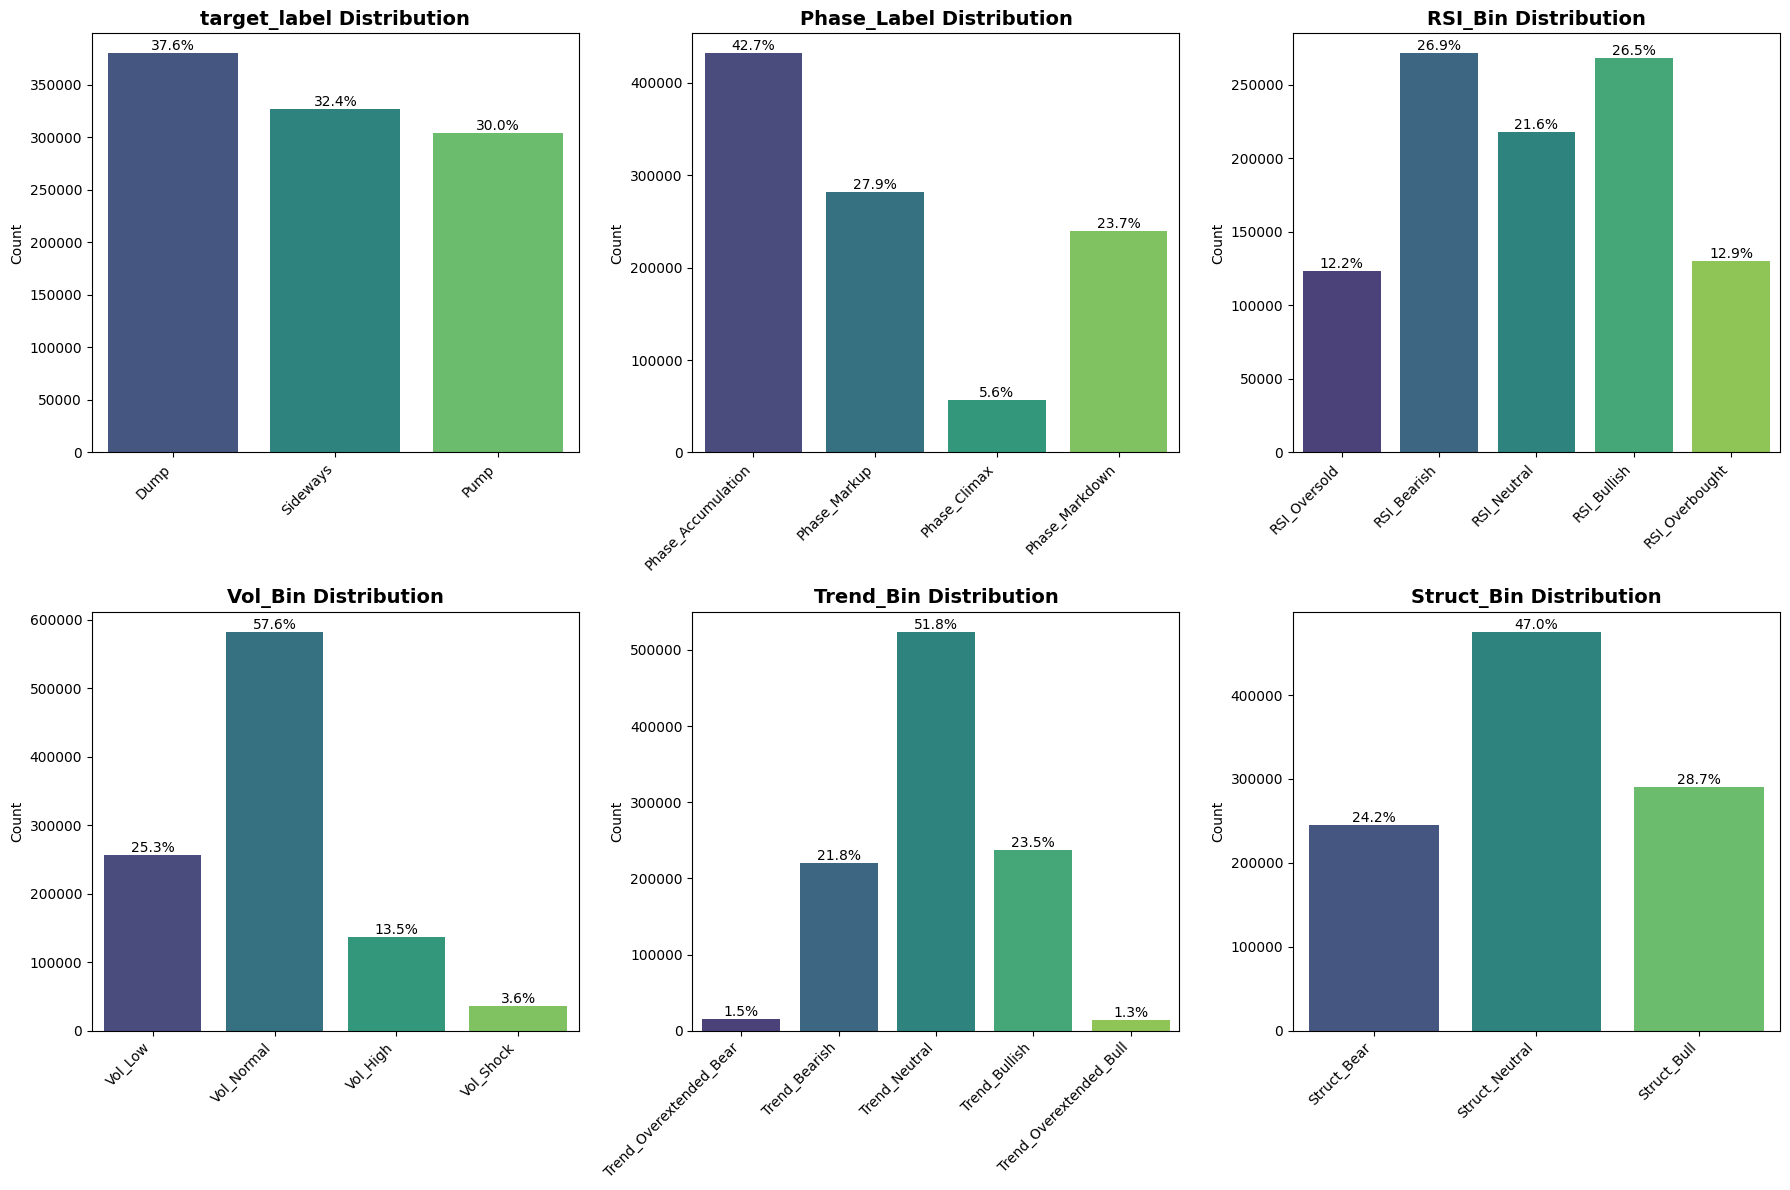

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 1. Define Logical Orders (Crucial for Ordinal Data)
orders = {
    'target_label': ['Dump', 'Sideways', 'Pump'],
    'Phase_Label':  ['Phase_Accumulation', 'Phase_Markup', 'Phase_Climax', 'Phase_Markdown'], # Cycle Order
    'RSI_Bin':      ['RSI_Oversold', 'RSI_Bearish', 'RSI_Neutral', 'RSI_Bullish', 'RSI_Overbought'],
    'Vol_Bin':      ['Vol_Low', 'Vol_Normal', 'Vol_High', 'Vol_Shock'],
    'Trend_Bin':    ['Trend_Overextended_Bear', 'Trend_Bearish', 'Trend_Neutral', 'Trend_Bullish', 'Trend_Overextended_Bull'],
    'Struct_Bin':   ['Struct_Bear', 'Struct_Neutral', 'Struct_Bull']
}

# 2. Plotting Function with Percentages
def plot_distributions(df):
    plt.figure(figsize=(18, 12))
    columns = ['target_label', 'Phase_Label', 'RSI_Bin', 'Vol_Bin', 'Trend_Bin', 'Struct_Bin']
    
    for i, col in enumerate(columns, 1):
        plt.subplot(2, 3, i)
        
        # Calculate percentages
        total = len(df)
        ax = sns.countplot(data=df, x=col, order=orders[col], palette='viridis')
        
        plt.title(f'{col} Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right') # Rotate labels to fit
        
        # Add Percentage Text on Bars
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

# Run it
plot_distributions(df_discretized)

In [152]:
df_discretized.to_csv("Data/bitcoin_data_discretized.csv", index=True)

## Pattern Mining

In [147]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

# Prepare transactions 
transactions = df_discretized.values.tolist()

# encode data
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# run FP-Growth
print("Running FP-Growth Algorithm...")
frequent_itemsets = fpgrowth(df_encoded, min_support=0.005, max_len=4, use_colnames=True)
print(f"Found {len(frequent_itemsets)} frequent itemsets.")

# Generate Association Rules
print("Generating Association Rules...")
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Convert frozensets to strings for better readability
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

# Find buy zones 
buy_zones = rules[
    (rules['consequents'] == 'Pump') & 
    (rules['lift'] > 1.1) & 
    (rules['confidence'] > 0.35)
].sort_values(by='confidence', ascending=False)

# Find sell zones
sell_zones = rules[
    (rules['consequents'] == 'Dump') & 
    (rules['lift'] > 1.1) & 
    (rules['confidence'] > 0.4)
].sort_values(by='confidence', ascending=False)

# Display Results
print("\n" + "="*40)
print("Top 10 Buy Zone Rules (Pump):")
print(buy_zones[['antecedents', 'support', 'confidence', 'lift']].head(10))
print("\n" + "="*40)
print("Top 10 Sell Zone Rules (Dump):")
print(sell_zones[['antecedents', 'support', 'confidence', 'lift']].head(10))


Running FP-Growth Algorithm...
Found 1780 frequent itemsets.
Generating Association Rules...

Top 10 Buy Zone Rules (Pump):
Empty DataFrame
Columns: [antecedents, support, confidence, lift]
Index: []

Top 10 Sell Zone Rules (Dump):
                                            antecedents   support  confidence  \
8408  RSI_Overbought, Trend_Neutral, Phase_Accumulation  0.012753    0.546669   
8415      RSI_Overbought, Trend_Neutral, Struct_Neutral  0.011080    0.527655   
304     Trend_Neutral, Phase_Accumulation, RSI_Oversold  0.013246    0.525386   
299         Trend_Neutral, RSI_Oversold, Struct_Neutral  0.011283    0.508834   
8357                      RSI_Overbought, Trend_Neutral  0.018941    0.507744   
8386          RSI_Overbought, Trend_Neutral, Vol_Normal  0.009320    0.500957   
8327        RSI_Overbought, Phase_Accumulation, Vol_Low  0.006671    0.495263   
8334             RSI_Overbought, Trend_Neutral, Vol_Low  0.006371    0.494814   
8230  RSI_Overbought, Phase_Accumulatio

In [150]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

# Prepare transactions 
transactions = df_discretized.values.tolist()

# encode data
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# run FP-Growth
print("Running FP-Growth Algorithm...")
frequent_itemsets = fpgrowth(df_encoded, min_support=0.001, use_colnames=True)
print(f"Found {len(frequent_itemsets)} frequent itemsets.")

# Generate Association Rules
print("Generating Association Rules...")
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Convert frozensets to strings for better readability
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

# Find buy zones 
buy_zones = rules[
    (rules['consequents'] == 'Pump') & 
    (rules['lift'] > 1.1) & 
    (rules['confidence'] > 0.35)
].sort_values(by='confidence', ascending=False)

# Find sell zones
sell_zones = rules[
    (rules['consequents'] == 'Dump') & 
    (rules['lift'] > 1.1) & 
    (rules['confidence'] > 0.4)
].sort_values(by='confidence', ascending=False)

# Display Results
print("\n" + "="*40)
print("Top 10 Buy Zone Rules (Pump):")
print(buy_zones[['antecedents', 'support', 'confidence', 'lift']].head(10))
print("\n" + "="*40)
print("Top 10 Sell Zone Rules (Dump):")
print(sell_zones[['antecedents', 'support', 'confidence', 'lift']].head(10))



Running FP-Growth Algorithm...
Found 4531 frequent itemsets.
Generating Association Rules...

Top 10 Buy Zone Rules (Pump):
                                             antecedents   support  \
33003  Phase_Climax, Trend_Neutral, RSI_Bearish, Vol_...  0.001171   
32989              Trend_Neutral, RSI_Bearish, Vol_Shock  0.001171   
15920  Phase_Climax, Trend_Neutral, RSI_Bearish, Stru...  0.001149   
2024   Vol_High, RSI_Oversold, Phase_Accumulation, St...  0.001451   
3821   Trend_Neutral, Phase_Accumulation, Struct_Bull...  0.001585   
15897           Phase_Climax, Trend_Neutral, RSI_Bearish  0.002175   
5732   Trend_Neutral, Phase_Accumulation, Struct_Bull...  0.001872   
15646  Trend_Neutral, Phase_Accumulation, Struct_Bull...  0.005709   
2076               Vol_High, Trend_Neutral, RSI_Oversold  0.001746   
15668  Vol_Normal, Trend_Neutral, Phase_Accumulation,...  0.003246   

       confidence      lift  
33003    0.363860  1.211248  
32989    0.363302  1.209389  
15920    0.3624

In [151]:
# Save rules to CSV
rules.to_csv("Data/association_rules_bitcoin2.csv", index=False)